<a href="https://colab.research.google.com/github/shima2920/data-analysis/blob/main/SIGNATE_Moving_Company_Forecast_20210211ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apple Moving Company demand forecast
https://signate.jp/competitions/269/data

In [52]:
#from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

## Import train and test data

In [53]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submit.csv')

# Checking data

In [54]:
train.head()

,datetime,y,client,close,price_am,price_pm
0,2010/7/1,17,0,0,-1,-1
1,2010/7/2,18,0,0,-1,-1
2,2010/7/3,20,0,0,-1,-1
3,2010/7/4,20,0,0,-1,-1
4,2010/7/5,14,0,0,-1,-1


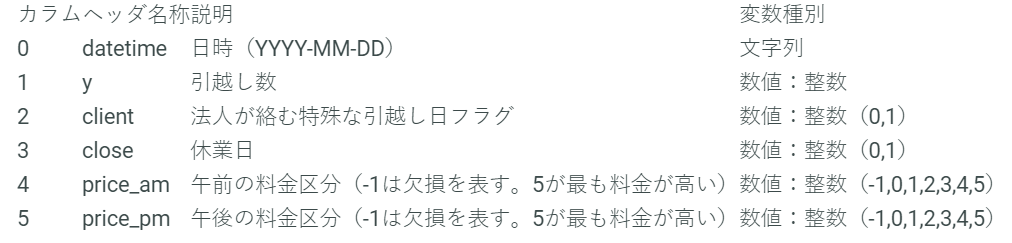


In [55]:
test.head()

,datetime,client,close,price_am,price_pm
0,2016/4/1,1,0,3,2
1,2016/4/2,0,0,5,5
2,2016/4/3,1,0,2,2
3,2016/4/4,1,0,1,1
4,2016/4/5,0,0,1,1


In [56]:
sample_submission.head()

,2016/4/1,65.98920574
0,2016/4/2,73.076330
1,2016/4/3,62.837857
2,2016/4/4,57.607645
3,2016/4/5,56.316084
4,2016/4/6,57.607645


In [57]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (2101, 6)
Testing Features shape:  (365, 5)


**data summary**

In [58]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

resumetable(train)[:25]

Dataset Shape: (2101, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,datetime,object,0,2101,2010/7/1,2010/7/2,2010/7/3,11.04
1,y,int64,0,99,17,18,20,6.01
2,client,int64,0,2,0,0,0,0.46
3,close,int64,0,2,0,0,0,0.10
4,price_am,int64,0,7,-1,-1,-1,2.03
5,price_pm,int64,0,7,-1,-1,-1,1.76


In [59]:
resumetable(test)[:25]

Dataset Shape: (365, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,datetime,object,0,365,2016/4/1,2016/4/2,2016/4/3,8.51
1,client,int64,0,2,1,0,1,0.99
2,close,int64,0,2,0,0,0,0.10
3,price_am,int64,0,7,3,5,2,1.81
4,price_pm,int64,0,7,2,5,2,1.58


**check missing value**

in these data, "-1" means missing value on columns price_am, price_pm

all the data is "-1" in 2010. so, remove 2010 data from dataframe.

In [60]:
train.replace([-1], np.nan, inplace=True)
train.head()

,datetime,y,client,close,price_am,price_pm
0,2010/7/1,17,0,0,NaN,NaN
1,2010/7/2,18,0,0,NaN,NaN
2,2010/7/3,20,0,0,NaN,NaN
3,2010/7/4,20,0,0,NaN,NaN
4,2010/7/5,14,0,0,NaN,NaN


In [61]:
train = train[187:]

In [62]:
train.to_csv('checking_data_before.csv', index=False)

In [63]:
train.shape

(1914, 6)

# how to deal with missing value

Change -1 -> NA

interpolae on forwarding value

In [64]:
train.fillna(method="ffill", inplace=True)

In [65]:
ms_count = train['price_am'].value_counts()
percent = ((train.isnull().sum()/train.shape[0])*100).sort_values(ascending=False)
print(ms_count)
print(type(ms_count))
print((211/train.shape[0])*100)

0.0    951
1.0    605
2.0    250
3.0     46
4.0     33
5.0     29
Name: price_am, dtype: int64
<class 'pandas.core.series.Series'>
11.024033437826542


In [66]:
ms_count = train['price_pm'].value_counts()
percent = ((train.isnull().sum()/train.shape[0])*100).sort_values(ascending=False)
print(ms_count)
print(type(ms_count))
print((211/train.shape[0])*100)

0.0    1198
1.0     497
2.0     138
3.0      38
4.0      30
5.0      13
Name: price_pm, dtype: int64
<class 'pandas.core.series.Series'>
11.024033437826542


In [67]:
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(434)

,Total,Percent
price_pm,0,0.0
price_am,0,0.0
close,0,0.0
client,0,0.0
y,0,0.0
datetime,0,0.0


In [68]:
train.to_csv('checking_data.csv', index=False)

# Visualization

Thin out every 5 days to make the Visualized data easier to see

In [69]:
#train_7D = train[::7]

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text major ticklabel objects>)

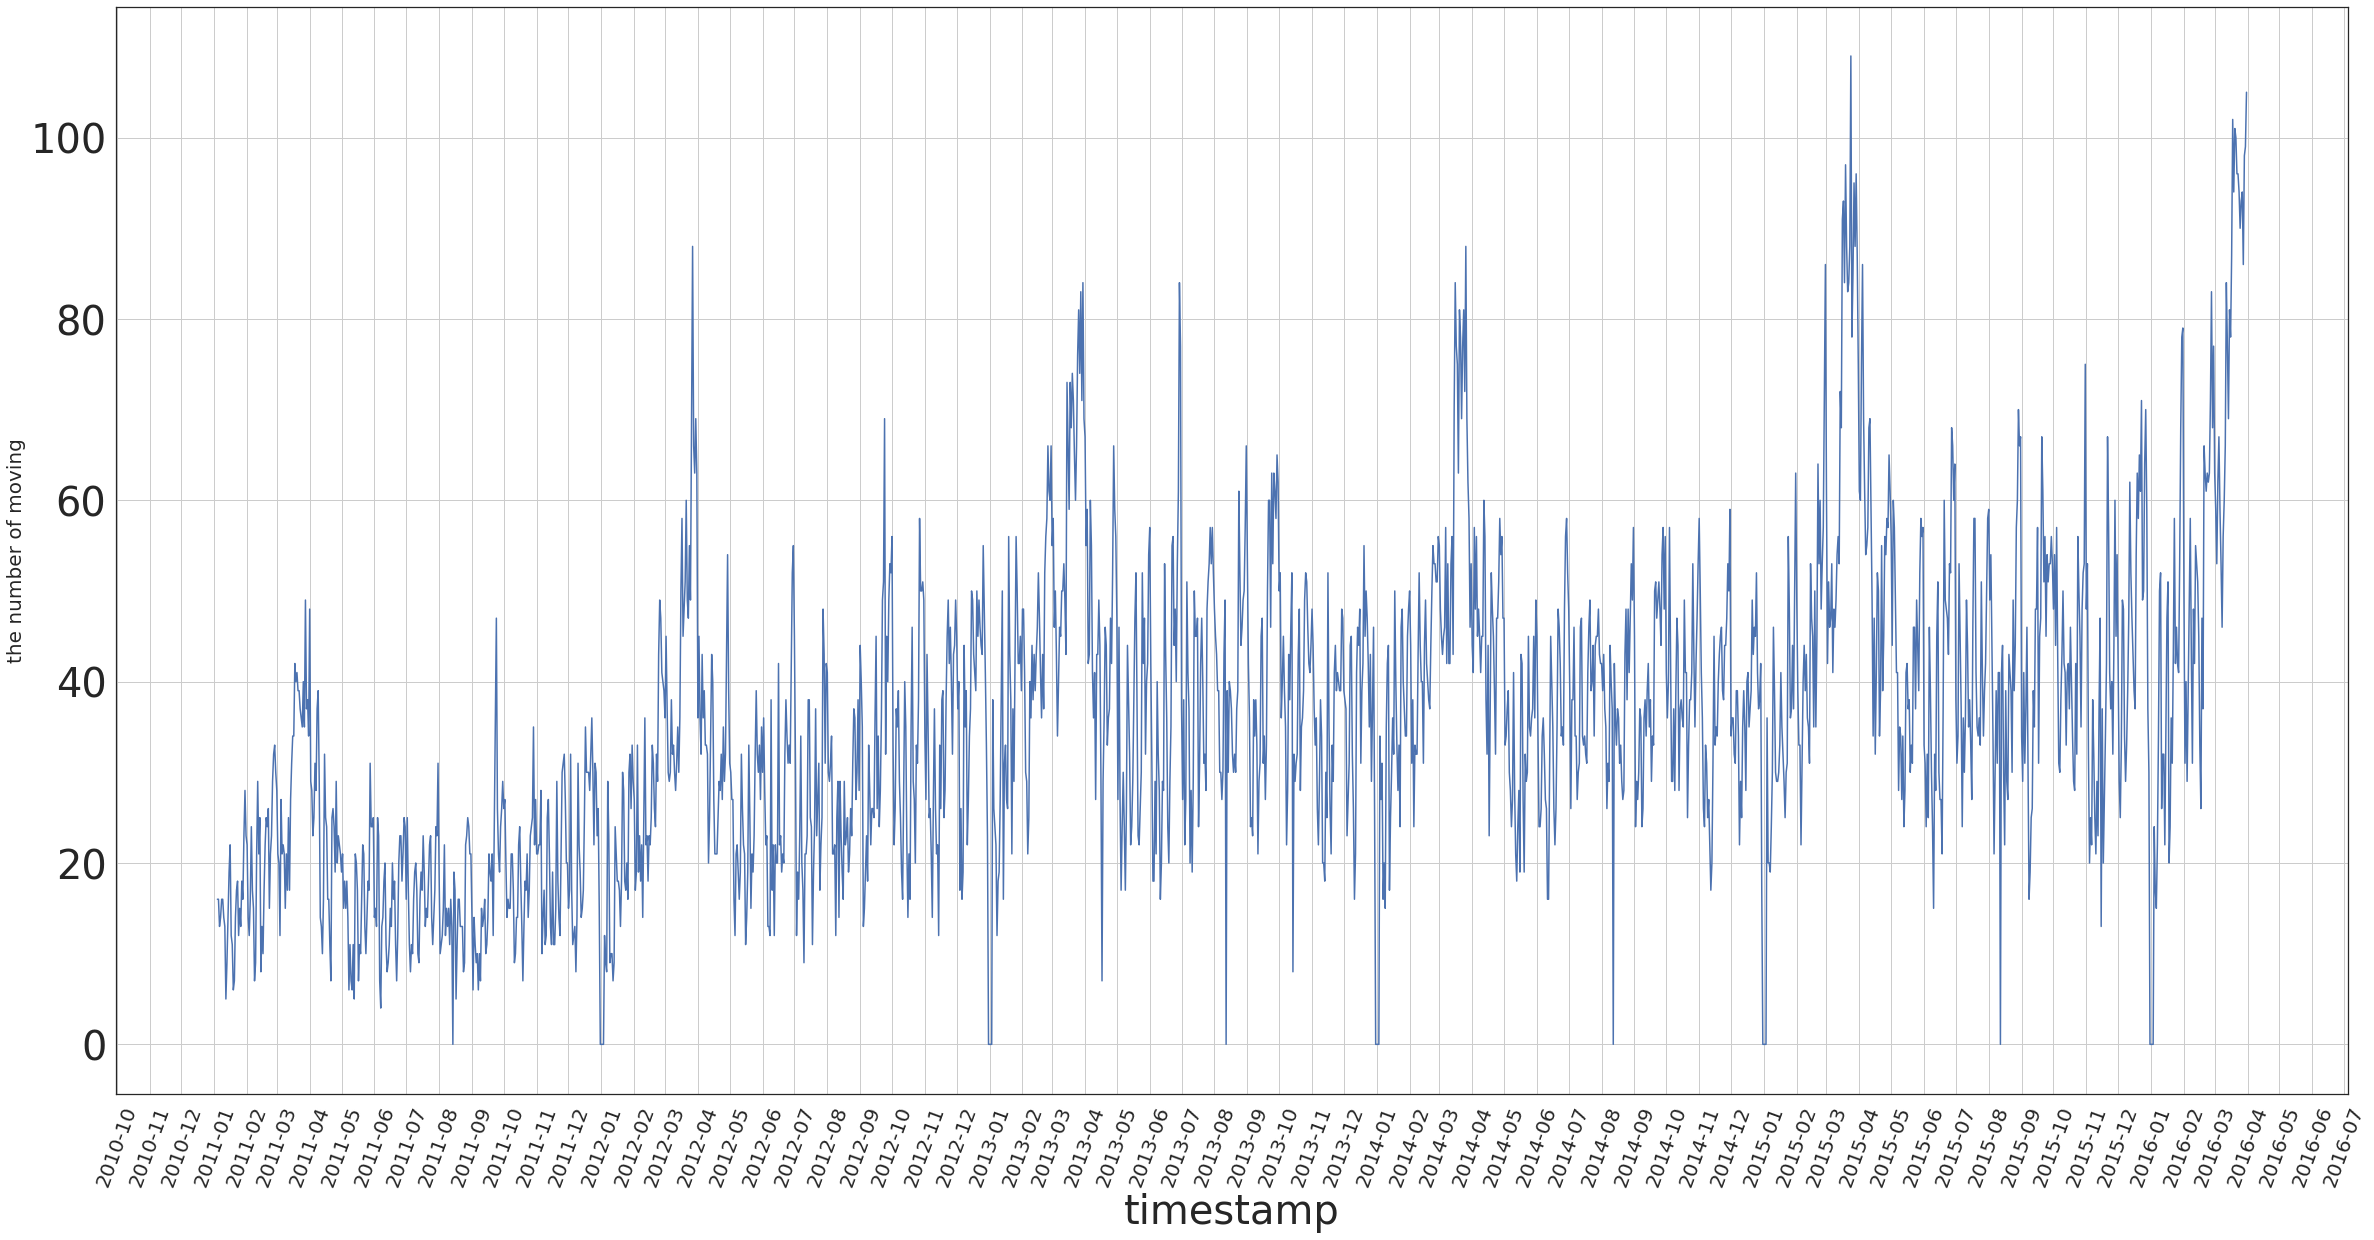

In [70]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(40, 20))
ax.plot(pd.to_datetime(train["datetime"]), train["y"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.grid()
plt.xlabel("timestamp", fontsize=40)
plt.ylabel("the number of moving", fontsize=20)
plt.xticks(fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=70)
plt.yticks(fontsize=40)
#plt.xticks(rotation=70)

the number of moving is increased in March and April every year

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text major ticklabel objects>)

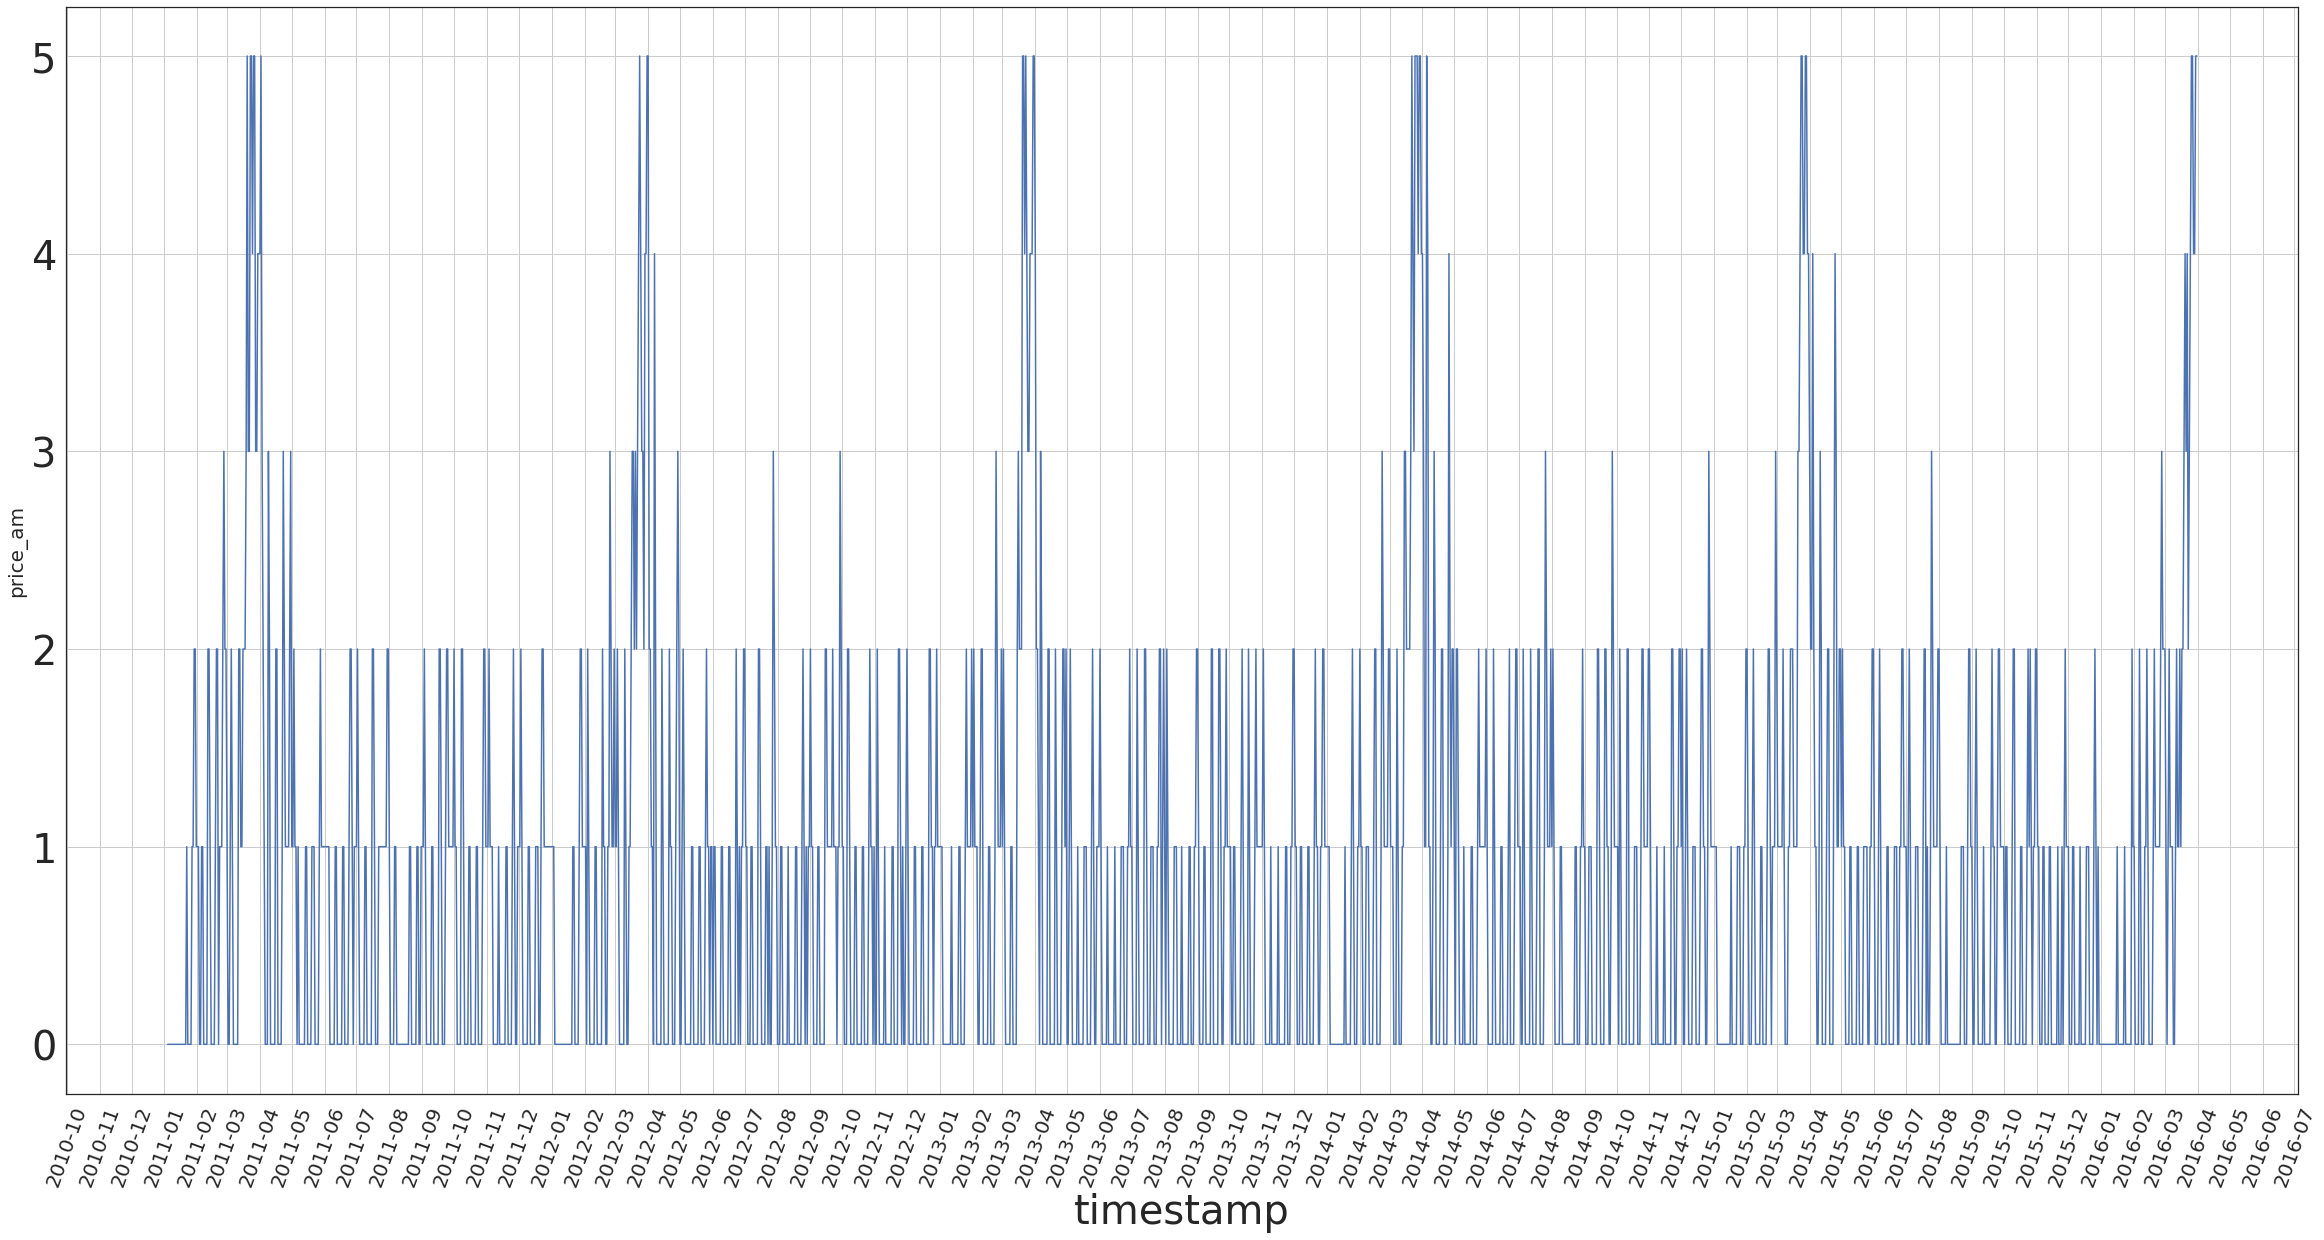

In [71]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(40, 20))
ax.plot(pd.to_datetime(train["datetime"]), train["price_am"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.grid()
plt.xlabel("timestamp", fontsize=40)
plt.ylabel("price_am", fontsize=20)
plt.xticks(fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=70)
plt.yticks(fontsize=40)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text major ticklabel objects>)

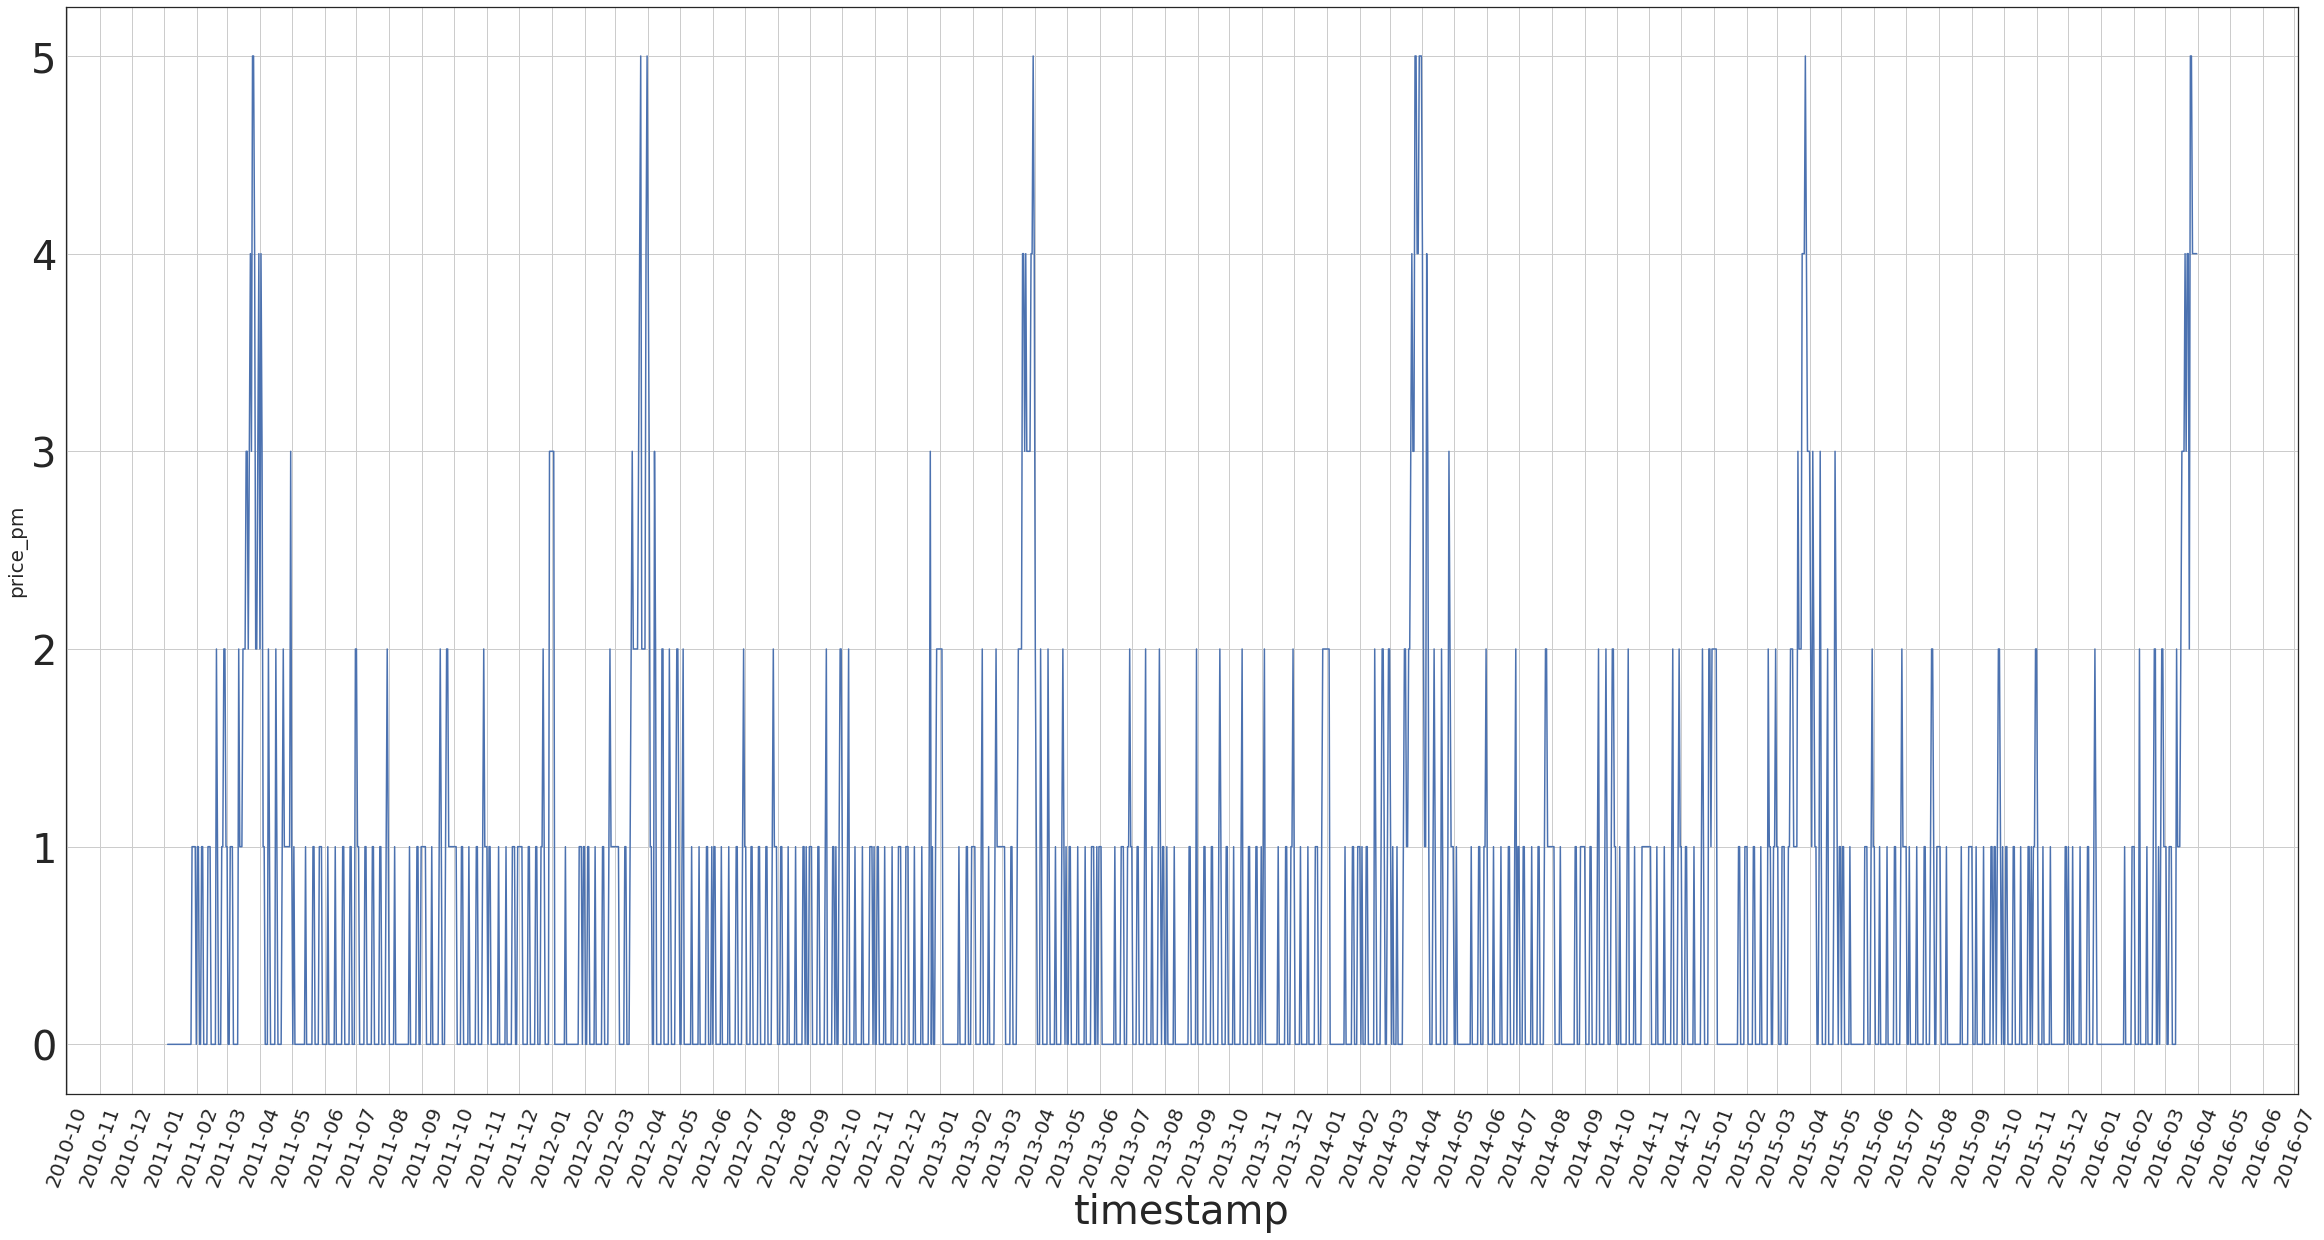

In [72]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(40, 20))
ax.plot(pd.to_datetime(train["datetime"]), train["price_pm"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.grid()
plt.xlabel("timestamp", fontsize=40)
plt.ylabel("price_pm", fontsize=20)
plt.xticks(fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=70)
plt.yticks(fontsize=40)

# split datetime

In [73]:
train["datetime"] = pd.to_datetime(train["datetime"])
train["Year"] = train["datetime"].apply(lambda x:x.year)
train["Month"] = train["datetime"].apply(lambda x:x.month)
train["Day"] = train["datetime"].apply(lambda x:x.day)
train = train.drop(['datetime'], axis = 1)

In [74]:
test["datetime"] = pd.to_datetime(test["datetime"])
test["Year"] = test["datetime"].apply(lambda x:x.year)
test["Month"] = test["datetime"].apply(lambda x:x.month)
test["Day"] = test["datetime"].apply(lambda x:x.day)
test = test.drop(['datetime'], axis = 1)

In [75]:
train.head()

,y,client,close,price_am,price_pm,Year,Month,Day
187,16,0,0,0.0,0.0,2011,1,4
188,16,0,0,0.0,0.0,2011,1,5
189,13,0,0,0.0,0.0,2011,1,6
190,14,0,0,0.0,0.0,2011,1,7
191,16,0,0,0.0,0.0,2011,1,8


In [76]:
test.head()

,client,close,price_am,price_pm,Year,Month,Day
0,1,0,3,2,2016,4,1
1,0,0,5,5,2016,4,2
2,1,0,2,2,2016,4,3
3,1,0,1,1,2016,4,4
4,0,0,1,1,2016,4,5


# Correlation

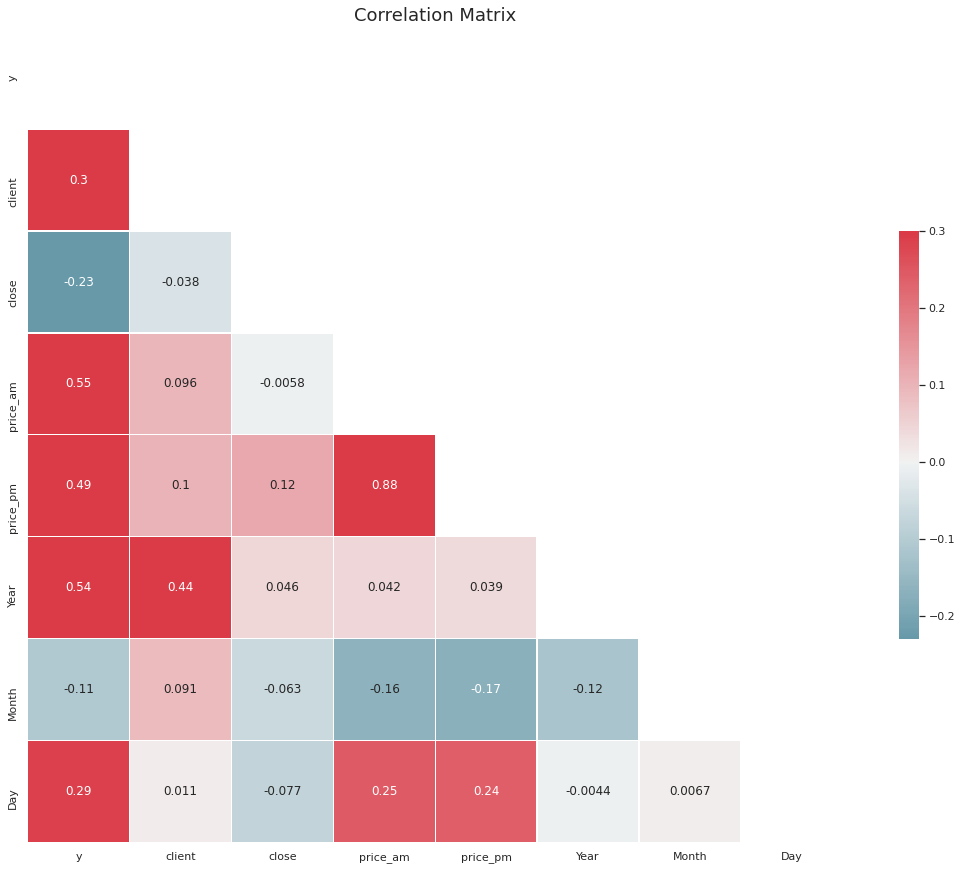

In [77]:
sns.set(style="white")
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

## Split data into y and x

In [78]:
x_train = train.drop(['y'], axis = 1)
y_train = train['y']
test = test

# Modeling

**RandomForest**

In [79]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [80]:
# Number of trees in random forest
n_estimators = [int(x) for x in range(200,2000,200)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [81]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf =  RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [82]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1600}

In [95]:
x_test

,client,close,price_am,price_pm,Year,Month,Day
1418,0,0,0.0,0.0,2014,5,19
298,0,0,1.0,1.0,2011,4,25
2034,0,0,0.0,0.0,2016,1,25
1910,0,0,0.0,1.0,2015,9,23
602,0,0,1.0,0.0,2012,2,23
1699,0,0,0.0,0.0,2015,2,24
257,0,0,1.0,1.0,2011,3,15
717,0,0,1.0,0.0,2012,6,17
804,0,0,0.0,0.0,2012,9,12
1223,0,0,0.0,0.0,2013,11,5


In [93]:
model = rf_random.best_estimator_
y_pred_test = model.predict(x_test)
model.score(y_pred_test, y_test)

ValueError: ignored

In [87]:
y_test
print('---------------------------------')
y_pred_test

---------------------------------


array([2.72600853e+01, 2.40976055e+01, 4.15840824e+01, 4.29570522e+01,
       2.73397884e+01, 3.95661127e+01, 2.26084963e+01, 2.44793465e+01,
       2.35368956e+01, 2.77852200e+01, 3.84399841e+01, 5.25838884e+01,
       3.37179600e+01, 7.67905833e+00, 2.22978410e+01, 4.51652040e+01,
       4.27828170e+01, 3.23870693e+01, 1.33224205e+01, 5.62960632e+01,
       1.39839437e+01, 3.08906497e+01, 2.03323783e+01, 2.56101172e+01,
       1.19396628e+01, 6.71458572e+01, 1.21408681e+01, 2.95238187e+01,
       4.59853433e+01, 4.05204529e+01, 3.76476538e+01, 2.34384298e+01,
       8.42236497e+01, 4.76164583e+01, 1.17799123e+01, 3.48088874e+01,
       2.67191833e+01, 8.39619361e+01, 2.46256603e+01, 5.13123961e+01,
       2.93043935e+01, 1.41203623e+01, 2.19190999e+01, 1.62584910e+01,
       3.83293498e+01, 3.54704513e+01, 2.23581428e+01, 5.42507290e+01,
       1.55385450e+01, 7.10887497e+01, 3.39969452e+01, 4.54944356e+01,
       4.54255679e+01, 2.14924624e+01, 1.31718442e+01, 4.64800411e+01,
      

In [ ]:
def get_accuracy(model,X_test, y_test):
    pred = model.predict(X_test)
    #print(pred)
    errors = abs(pred - y_test)
    print(errors)
    MSE=round(np.mean(errors),2)
    print(MSE)
    MAPE=100*(errors/y_test)
    print(MAPE)
    accuracy=round (100 - np.mean(MAPE),2)
    return accuracy 


best_random = rf_random.best_estimator_
get_accuracy(best_random, x_test, y_test)

In [ ]:
model = rf_random.best_estimator_
y_pred_test = model.predict(x_test)

In [ ]:
accuracy_score = model.score()

In [ ]:
model = rf_random.best_estimator_
y_pred = model.predict(test)
y_pred

# Submit

In [ ]:
#Submit方法
#sub = pd.DataFrame(pd.read_csv('test.csv')['datetime'])
#sub['y'] = list(map(float, y_pred))
#sub.to_csv('submission_yshimamu_RandomForest.csv', index=False)

In [ ]:
sample_submission[1] = np.array(y_pred) + 1
#日付の区切りを'/'から'-'へ
sample_submission[0] = pd.to_datetime(sample_submission[0])
sample_submission.to_csv('submit_RandomForest.csv', header=False, index=False)